In [7]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections

import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [8]:
env = gym.envs.make("MountainCarContinuous-v0")
env.observation_space.sample()

[2016-10-01 17:53:25,157] Making new env: MountainCarContinuous-v0


array([-0.21213569,  0.03012651])

In [9]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

In [10]:
def featurize_state(state):
    """
    Returns the featurized representation for a state.
    """
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]

In [56]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.action = tf.placeholder(dtype=tf.float32, name="action")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just linear classifier
            self.mu = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            self.mu = tf.squeeze(self.mu)
            
            self.sigma = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            
            self.sigma = tf.squeeze(self.sigma)
            self.sigma = tf.nn.softplus(self.sigma) + 1e-5
            self.normal_dist = tf.contrib.distributions.Normal(self.mu, self.sigma)
            self.action = self.normal_dist.sample_n(1)
            self.action = tf.clip_by_value(self.action, env.action_space.low[0], env.action_space.high[0])

            # Loss and train op
            self.loss = -self.normal_dist.log_prob(self.action) * self.target
            # Add cross entropy cost to encourage exploration
            self.loss -= 1e-1 * self.normal_dist.entropy()
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.action, { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [57]:
class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just linear classifier
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [58]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = env.reset()
        
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # env.render()
            
            # Take a step
            action = estimator_policy.predict(state)
            next_state, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Calculate TD Target
            value_next = estimator_value.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - estimator_value.predict(state)
            
            # Update the value estimator
            estimator_value.update(state, td_target)
            
            # Update the policy estimator
            # using the td error as our advantage estimate
            estimator_policy.update(state, td_error, action)
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")

            if done:
                break
                
            state = next_state
    
    return stats

In [59]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator(learning_rate=0.001)
value_estimator = ValueEstimator(learning_rate=0.1)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # TODO: Sometimes the algorithm gets stuck, I'm not sure what exactly is happening there.
    stats = actor_critic(env, policy_estimator, value_estimator, 50, discount_factor=0.95)

Step 168 @ Episode 50/50 (-7.791017010758367)

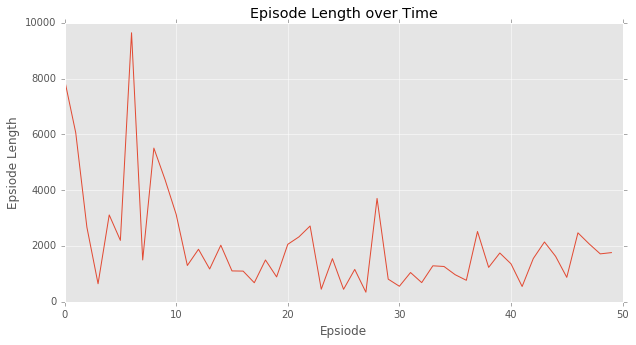

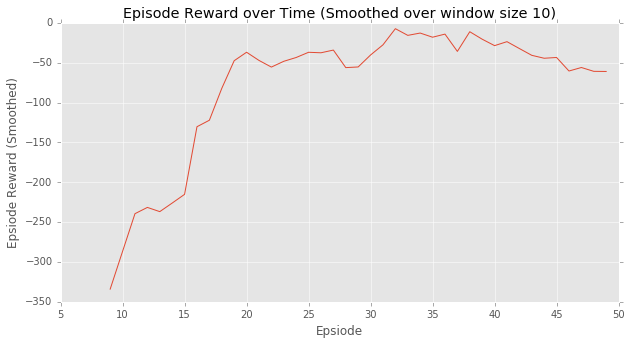

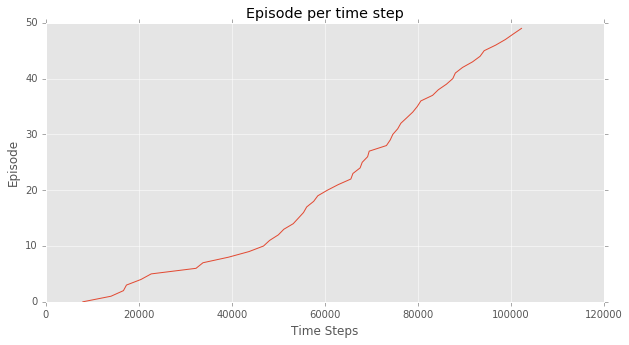

(<matplotlib.figure.Figure at 0x10e4de710>,
 <matplotlib.figure.Figure at 0x116414da0>)

In [24]:
plotting.plot_episode_stats(stats, smoothing_window=10)